## Expert Knowledge Worker

### A question answering agent that is an expert knowledge worker
### To be used by employees of Insurellm, an Insurance Tech company
### The agent needs to be accurate and the solution should be low cost.

This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

In [3]:
import sys
sys.path.append('/run/media/sijanpaudel/New Volume/New folder/llm_engineering')

In [4]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from key_utils import get_next_key

In [5]:
# imports for langchain and Chroma and plotly

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [12]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "models/gemini-embedding-001"
db_name = "vector_db"

In [ ]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [7]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

# Please note:

In the next cell, we split the text into chunks.

2 students let me know that the next cell crashed their computer.  
They were able to fix it by changing the chunk_size from 1,000 to 2,000 and the chunk_overlap from 200 to 400.  
This shouldn't be required; but if it happens to you, please make that change!  
(Note that LangChain may give a warning about a chunk being larger than 1,000 - this can be safely ignored).

_With much thanks to Steven W and Nir P for this valuable contribution._

In [8]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [9]:
len(chunks)

123

In [10]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: company, products, employees, contracts


## A sidenote on Embeddings, and "Auto-Encoding LLMs"

We will be mapping each chunk of text into a Vector that represents the meaning of the text, known as an embedding.

OpenAI offers a model to do this, which we will use by calling their API with some LangChain code.

This model is an example of an "Auto-Encoding LLM" which generates an output given a complete input.
It's different to all the other LLMs we've discussed today, which are known as "Auto-Regressive LLMs", and generate future tokens based only on past context.

Another example of an Auto-Encoding LLMs is BERT from Google. In addition to embedding, Auto-encoding LLMs are often used for classification.

### Sidenote

In week 8 we will return to RAG and vector embeddings, and we will use an open-source vector encoder so that the data never leaves our computer - that's an important consideration when building enterprise systems and the data needs to remain internal.

In [ ]:

doc1 = Document(
    page_content="Virat Kohli is one of the most successful and consistent batsmen in IPL history. Known for his aggressive batting style and fitness, he has led the Royal Challengers Bangalore in multiple seasons.",
    metadata={"team": "Royal Challengers Bangalore"}
)
doc2 = Document(
    page_content="Rohit Sharma is the most successful captain in IPL history, leading Mumbai Indians to five titles. He's known for his calm demeanor and ability to play big innings under pressure.",
    metadata={"team": "Mumbai Indians"}
)
doc3 = Document(
    page_content="MS Dhoni, famously known as Captain Cool, has led Chennai Super Kings to multiple IPL titles. His finishing skills, wicketkeeping, and leadership are legendary.",
    metadata={"team": "Chennai Super Kings"}
)
doc4 = Document(
    page_content="Jasprit Bumrah is considered one of the best fast bowlers in T20 cricket. Playing for Mumbai Indians, he is known for his yorkers and death-over expertise.",
    metadata={"team": "Mumbai Indians"}
)
doc5 = Document(
    page_content="Ravindra Jadeja is a dynamic all-rounder who contributes with both bat and ball. Representing Chennai Super Kings, his quick fielding and match-winning performances make him a key player.",
    metadata={"team": "Chennai Super Kings"}
)

docs = [doc1, doc2, doc3, doc4, doc5]

vector_store = Chroma(
    embedding_function=GoogleGenerativeAIEmbeddings(
        model="models/gemini-embedding-001"),
    persist_directory='my_chroma_db',
    collection_name='sample'
)

# add documents
for doc in docs:
    vector_store.add_documents([doc])

# view documents
vector_store.get(include=['embeddings', 'documents', 'metadatas'])

# search documents
vector_store.similarity_search(
    query='Who among these are a bowler?',
    k=2
)

# search documents with similarity score
vector_store.similarity_search_with_score(
    query='Who among these are a bowler?',
    k=2
)

# meta-data filtering
# vector_store.similarity_search_with_score(
#     query="",
#     filter={'team': "Chennai Super Kings"}
# )

# update documents
updated_doc1 = Document(
    page_content="Virat Kohli, the former captain of Royal Challengers Bangalore (RCB), is renowned for his aggressive leadership and consistent batting performances. He holds the record for the most runs in IPL history, including multiple centuries in a single season. Despite RCB not winning an IPL title under his captaincy, Kohli's passion and fitness set a benchmark for the league. His ability to chase targets and anchor innings has made him one of the most dependable players in T20 cricket.",
    metadata={"team": "Royal Challengers Bangalore"}
)

vector_store.update_document(
    document_id='09a39dc6-3ba6-4ea7-927e-fdda591da5e4', document=updated_doc1)

# view documents
vector_store.get(include=['embeddings', 'documents', 'metadatas'])

# delete document
vector_store.delete(ids=['09a39dc6-3ba6-4ea7-927e-fdda591da5e4'])

# view documents
vector_store.get(include=['embeddings', 'documents', 'metadatas'])


In [35]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
import sys
sys.path.append('/run/media/sijanpaudel/New Volume/New folder/llm_engineering')
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from key_utils import get_next_key
api_key, _ = get_next_key()
os.environ["GOOGLE_API_KEY"] =api_key
embeddings = GoogleGenerativeAIEmbeddings(model= MODEL)
# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [17]:
# Check if a Chroma Datastore already exists - if so, delete the collection to start from scratch

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [31]:
len(chunks)

123

In [21]:
chunks[:20]

[Document(metadata={'source': 'knowledge-base/company/about.md', 'doc_type': 'company'}, page_content="# About Insurellm\n\nInsurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. It's first product was Markellm, the marketplace connecting consumers with insurance providers.\nIt rapidly expanded, adding new products and clients, reaching 200 emmployees by 2024 with 12 offices across the US."),
 Document(metadata={'source': 'knowledge-base/company/careers.md', 'doc_type': 'company'}, page_content='# Careers at Insurellm\n\nInsurellm is hiring! We are looking for talented software engineers, data scientists and account executives to join our growing team. Come be a part of our movement to disrupt the insurance sector.'),
 Document(metadata={'source': 'knowledge-base/company/overview.md', 'doc_type': 'company'}, page_content='# Overview of Insurellm\n\nInsurellm is an innovative insurance tech firm with 

In [36]:
# Create our Chroma vectorstore!

vectorstore = Chroma.from_documents(documents=chunks[:90], embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 240 documents


In [37]:
# Get one vector and find how many dimensions it has

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 3,072 dimensions


In [38]:
sample_embedding

array([-0.01169936,  0.03467642,  0.0108306 , ...,  0.0079027 ,
        0.00697009, -0.01372486])

## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

In [39]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

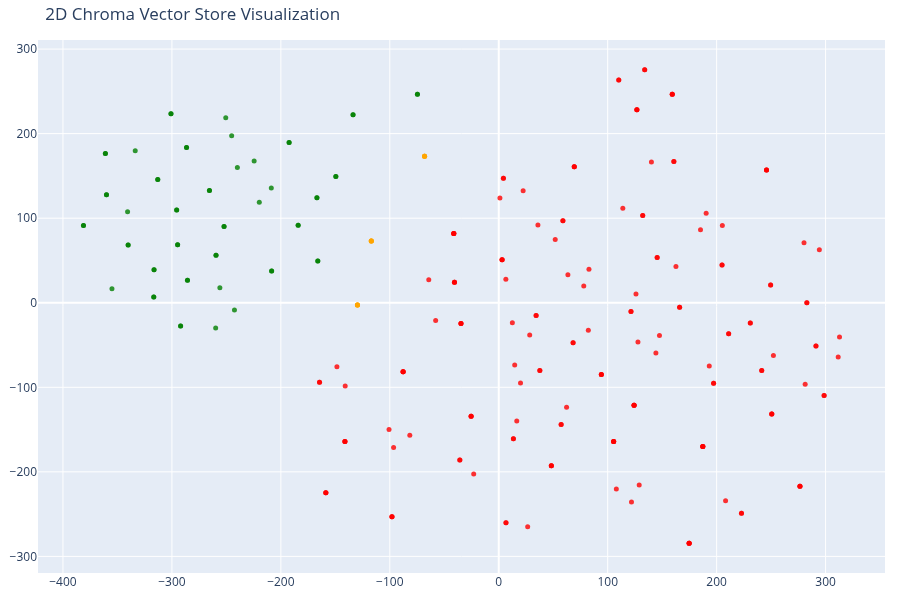

In [41]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42) 
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

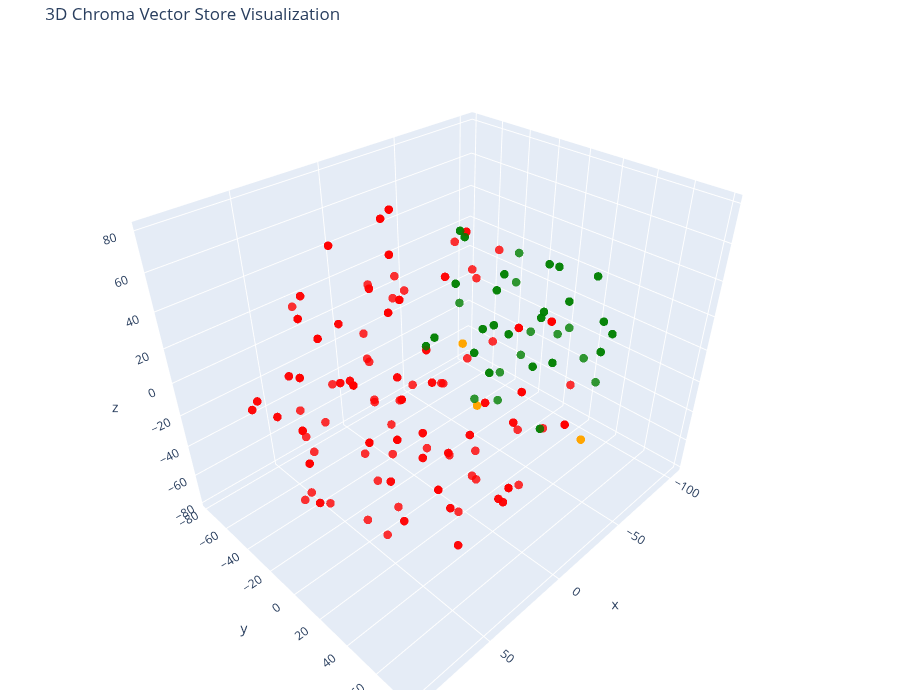

In [42]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()